# Litecoin Price Prediction 2021

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,accuracy_score,mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional, GRU
from keras.models import Sequential

from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from kerastuner.tuners import BayesianOptimization
from keras.regularizers import l2

## Data Preprocessing

In [2]:
df = pd.read_csv('Data/coin_Litecoin.csv')

In [3]:
df.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Litecoin,LTC,2013-04-29 23:59:59,4.57360,4.22564,4.36676,4.38390,0.0,7.538896e+07
1,2,Litecoin,LTC,2013-04-30 23:59:59,4.57238,4.16896,4.40352,4.29649,0.0,7.402092e+07
2,3,Litecoin,LTC,2013-05-01 23:59:59,4.35686,3.52029,4.28954,3.80101,0.0,6.560460e+07
3,4,Litecoin,LTC,2013-05-02 23:59:59,4.03930,3.00717,3.78002,3.37198,0.0,5.828798e+07
4,5,Litecoin,LTC,2013-05-03 23:59:59,3.45361,2.39594,3.39044,3.04491,0.0,5.269485e+07


In [4]:
#spliting 'Date' column to 'date' and 'time'
df['Date'] = pd.to_datetime(df['Date'])
df['date'] = df['Date'].dt.date
df['time'] = df['Date'].dt.time

#drop non-relevant columns
df.drop(['SNo','Name','Symbol','Date','time'], axis=1, inplace=True)

#set date as new index
df.set_index('date',inplace=True)

df.head()

,High,Low,Open,Close,Volume,Marketcap
date,,,,,,
2013-04-29,4.57360,4.22564,4.36676,4.38390,0.0,7.538896e+07
2013-04-30,4.57238,4.16896,4.40352,4.29649,0.0,7.402092e+07
2013-05-01,4.35686,3.52029,4.28954,3.80101,0.0,6.560460e+07
2013-05-02,4.03930,3.00717,3.78002,3.37198,0.0,5.828798e+07
2013-05-03,3.45361,2.39594,3.39044,3.04491,0.0,5.269485e+07


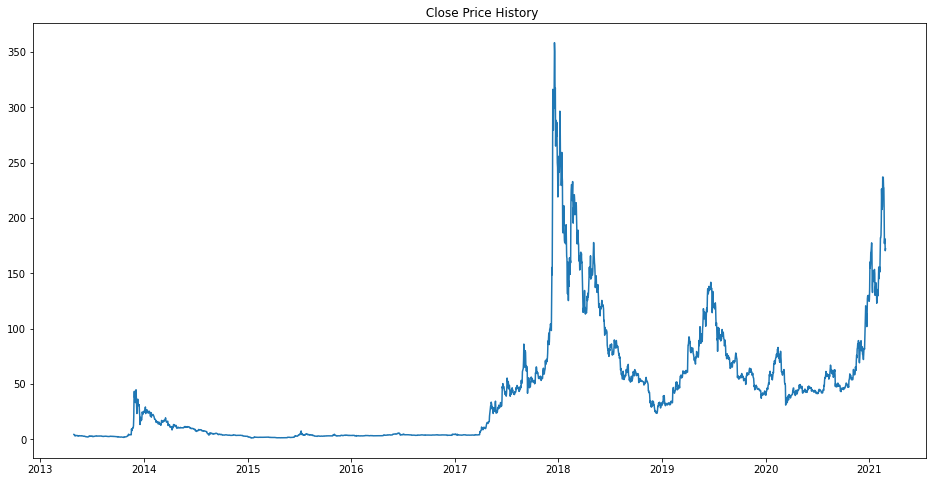

In [5]:
plt.figure(figsize=(16,8))
plt.title(' Close Price History')
plt.plot(df['Close'])

## Train, Validation and Test Data

In [6]:
n = df.shape[0]
train_df = df[0:int(n*.7)]
val_df = df[int(n*0.7):int(n*0.85)]
test_df = df[int(n*0.85):]

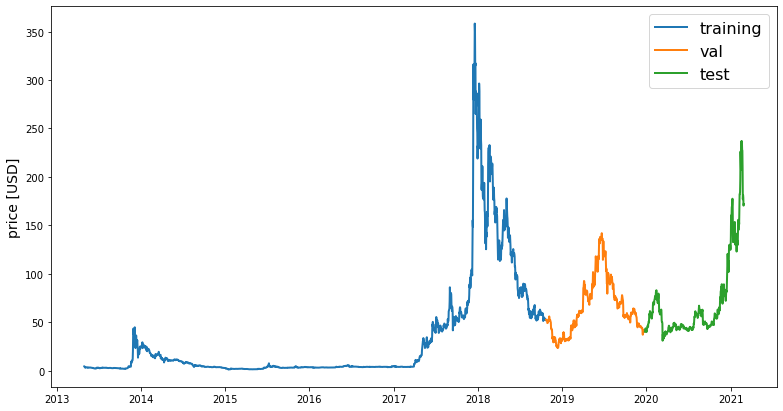

In [7]:
def line_plot2(line1, line2,label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)

def line_plot3(line1, line2,line3, label1=None, label2=None,label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)


line_plot3(line1 = train_df.filter(['Close']), 
          line2 = val_df.filter(['Close']),
          line3 = test_df.filter(['Close']), label1='training',label2='val',label3= 'test', title='')

## Data Normalization

In [8]:
def scale_func(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_data = pd.DataFrame(scaled_data,index=df.index, columns=df.columns)
    return scaled_data, scaler

scaled_train_df, scaler  = scale_func(train_df) 
scaled_val_df = pd.DataFrame(scaler.transform(val_df),index=val_df.index,columns=val_df.columns)
scaled_test_df = pd.DataFrame(scaler.transform(test_df),index=test_df.index,columns=test_df.columns)

In [9]:
#create the training data set
def generate_input(df, window, target):
    #create the scaled training data set
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    for i in range(window, len(df)):
        x_train.append(df.iloc[i-window:i, :][target])
        y_train.append(df.iloc[i,:,][target])
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    return x_train, y_train
def multiinput_generator(df, target, window):
    feature_cols = df.columns  
    x_train = []
    y_train = []
    for i in range(window, len(df)):
        x_train.append(df.iloc[i-window:i,:])
        y_train.append(df.iloc[i,:][target])
    #convert x_train and y_train to numpy arrays
    x_train, y_train = np.array(x_train), np.array(y_train)
    return x_train,y_train


In [10]:
x_train, y_train = generate_input(scaled_train_df,15, "Close")
#convert x_train and y_train to numpy arrays
x_val, y_val = generate_input(scaled_val_df,15, "Close")
x_test, y_test = generate_input(scaled_test_df,15, "Close")

print("Training set:",x_train.shape)
print("Validation set:",x_val.shape)
print("Test set:",x_test.shape)

Training set: (1988, 15, 1)
Validation set: (414, 15, 1)
Test set: (415, 15, 1)


## Modeling

In [11]:
def model_base_build(input_shape):
    #build the lstm model
    model = Sequential()
    model.add(LSTM(100, return_sequences=True,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), input_shape = input_shape))
    model.add(LSTM(100, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1))
    model.add(Activation('linear'))
    #compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def model_class_build(input_shape):
    #build the lstm model
    model = Sequential()
    #### Adding the first LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.2))
    #### Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    #### Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    #### Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    #### Adding the output layer
    model.add(Dense(units = 1))
    model.add(Activation('linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def model_GRU_build(input_shape):
    model = Sequential()
    # Input layer
    model.add(GRU(120,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), return_sequences = True, input_shape = input_shape))
    model.add(Dropout(0.4)) 
    # Hidden layer
    model.add(GRU(120)) 
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def biLSTM_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(210,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), return_sequences=True, input_shape = (x_train.shape[1],1))))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(210)))
    model.add(Dropout(0.4))
    model.add(Dense(1))
    model.add(Activation('linear'))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [12]:
def accuracy_forecast(target_val ,prediction_val):   
    bi_targ = np.sign(target_val.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]))[1:].values
    bi_pred = np.sign(prediction_val.rolling(window=2).apply(lambda x: x.iloc[1] - x.iloc[0]))[1:].values
    return accuracy_score(bi_targ,bi_pred)

In [13]:
LSTM1 = model_base_build(input_shape= (x_train.shape[1],x_train.shape[2]))
LSTM2 = model_class_build(input_shape= (x_train.shape[1],x_train.shape[2]))
GRU_model = model_GRU_build(input_shape= (x_train.shape[1],x_train.shape[2]))
biLSTM = biLSTM_model(input_shape= (x_train.shape[1],x_train.shape[2]))

In [14]:
#train the model
history1 = LSTM1.fit(x_train, y_train, batch_size=32, epochs=80,validation_data=(x_val,y_val))
history2 = LSTM2.fit(x_train, y_train, batch_size=32, epochs=80,validation_data=(x_val,y_val))
history3 = GRU_model.fit(x_train, y_train, batch_size=32, epochs=80,validation_data=(x_val,y_val))
history4 = biLSTM.fit(x_train, y_train, batch_size=32, epochs=80,validation_data=(x_val,y_val))

===============] - 2s 32ms/step - loss: 6.3625e-04 - val_loss: 1.7885e-04
Epoch 49/80
63/63 [==============================] - 2s 39ms/step - loss: 5.4760e-04 - val_loss: 6.2945e-04
Epoch 50/80
63/63 [==============================] - 2s 35ms/step - loss: 9.3659e-04 - val_loss: 1.8218e-04
Epoch 51/80
63/63 [==============================] - 2s 30ms/step - loss: 6.0176e-04 - val_loss: 1.7886e-04
Epoch 52/80
63/63 [==============================] - 2s 36ms/step - loss: 6.8175e-04 - val_loss: 1.8289e-04
Epoch 53/80
63/63 [==============================] - 2s 32ms/step - loss: 6.7867e-04 - val_loss: 1.7391e-04
Epoch 54/80
63/63 [==============================] - 2s 34ms/step - loss: 6.0481e-04 - val_loss: 5.3355e-04
Epoch 55/80
63/63 [==============================] - 2s 30ms/step - loss: 9.2734e-04 - val_loss: 1.6679e-04
Epoch 56/80
63/63 [==============================] - 2s 27ms/step - loss: 7.1808e-04 - val_loss: 3.0848e-04
Epoch 57/80
63/63 [==============================] - 2s 36ms/s

## Model Optimization

In [15]:
'''def build_model_LSTM1(hp):
    #build the lstm model
    model = Sequential()
    model.add(LSTM(hp.Int("input_units1", min_value=40,max_value=120, step=10),kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), return_sequences=True, input_shape = (x_train.shape[1],x_train.shape[2])))
    model.add(LSTM(hp.Int("input_units2", min_value=40,max_value=120, step=10),kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1))
    model.add(Activation('linear'))
    #compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model'''

'def build_model_LSTM1(hp):\n    #build the lstm model\n    model = Sequential()\n    model.add(LSTM(hp.Int("input_units1", min_value=40,max_value=120, step=10),kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), return_sequences=True, input_shape = (x_train.shape[1],x_train.shape[2])))\n    model.add(LSTM(hp.Int("input_units2", min_value=40,max_value=120, step=10),kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01), return_sequences=False, dropout=0.2, recurrent_dropout=0.2))\n    model.add(Dense(1))\n    model.add(Activation(\'linear\'))\n    #compile the model\n    model.compile(optimizer=\'adam\', loss=\'mean_squared_error\')\n    return model'

In [16]:
'''tuner_LSTM = BayesianOptimization(
    build_model_LSTM1,
    objective = "val_loss",
    max_trials = 10,
    executions_per_trial = 1,
    directory='my_dir',
    project_name='helloworld',
    overwrite=True
 )'''

'tuner_LSTM = BayesianOptimization(\n    build_model_LSTM1,\n    objective = "val_loss",\n    max_trials = 10,\n    executions_per_trial = 1,\n    directory=\'my_dir\',\n    project_name=\'helloworld\',\n    overwrite=True\n )'

In [17]:
'''tuner_LSTM.search(x = x_train,
             y = y_train,
             epochs=100,
             batch_size=32,
             validation_data=(x_val,y_val))

print(tuner_LSTM.get_best_hyperparameters()[0].values)

print(tuner_LSTM.results_summary())'''

'tuner_LSTM.search(x = x_train,\n             y = y_train,\n             epochs=100,\n             batch_size=32,\n             validation_data=(x_val,y_val))\n\nprint(tuner_LSTM.get_best_hyperparameters()[0].values)\n\nprint(tuner_LSTM.results_summary())'

In [18]:
'''def build_model(hp):
 #   model = Sequential()
#
#    model.add(Bidirectional(LSTM((210), return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]))))
#    model.add(Dropout(0.2))

#    model.add(Bidirectional(LSTM(hp.Int("input_units2", min_value=210,max_value=220, step=5))))
#    model.add(Dropout(0.2))

#    model.add(Dense(1))
#    model.add(Activation('linear'))

#    model.compile(optimizer='adam', loss='mean_squared_error')

#    return model'''

'def build_model(hp):\n #   model = Sequential()\n#\n#    model.add(Bidirectional(LSTM((210), return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2]))))\n#    model.add(Dropout(0.2))\n\n#    model.add(Bidirectional(LSTM(hp.Int("input_units2", min_value=210,max_value=220, step=5))))\n#    model.add(Dropout(0.2))\n\n#    model.add(Dense(1))\n#    model.add(Activation(\'linear\'))\n\n#    model.compile(optimizer=\'adam\', loss=\'mean_squared_error\')\n\n#    return model'

In [19]:
'''tuner = BayesianOptimization(
    build_model,
    objective = "val_loss",
    max_trials = 5,
    executions_per_trial = 1,
    directory='my_dir',
    project_name='helloworld',
    overwrite=True
 )'''

'tuner = BayesianOptimization(\n    build_model,\n    objective = "val_loss",\n    max_trials = 5,\n    executions_per_trial = 1,\n    directory=\'my_dir\',\n    project_name=\'helloworld\',\n    overwrite=True\n )'

In [20]:
'''tuner.search(x = x_train,
             y = y_train,
             epochs=100,
             batch_size=32,
             validation_data=(x_val,y_val))

print(tuner.get_best_hyperparameters()[0].values)

print(tuner.results_summary())'''

'tuner.search(x = x_train,\n             y = y_train,\n             epochs=100,\n             batch_size=32,\n             validation_data=(x_val,y_val))\n\nprint(tuner.get_best_hyperparameters()[0].values)\n\nprint(tuner.results_summary())'

In [21]:
'''def build_model2(hp):

    model = Sequential()
    # Input layer
    model.add(GRU(hp.Int("input_units1", min_value=100,max_value=125, step=5), return_sequences = True, input_shape=(x_train.shape[1],x_train.shape[2])))
    model.add(Dropout(0.4))

    # Hidden layer
    model.add(GRU(hp.Int("input_units2", min_value=100,max_value=125, step=5))) 
    model.add(Dropout(0.4))

    model.add(Dense(1))
    model.add(Activation('linear'))

    model.compile(optimizer='adam', loss='mean_squared_error')

    return model'''

'def build_model2(hp):\n\n    model = Sequential()\n    # Input layer\n    model.add(GRU(hp.Int("input_units1", min_value=100,max_value=125, step=5), return_sequences = True, input_shape=(x_train.shape[1],x_train.shape[2])))\n    model.add(Dropout(0.4))\n\n    # Hidden layer\n    model.add(GRU(hp.Int("input_units2", min_value=100,max_value=125, step=5))) \n    model.add(Dropout(0.4))\n\n    model.add(Dense(1))\n    model.add(Activation(\'linear\'))\n\n    model.compile(optimizer=\'adam\', loss=\'mean_squared_error\')\n\n    return model'

In [22]:
'''tuner2 = BayesianOptimization(
    build_model2,
    objective = "val_loss",
    max_trials = 5,
    executions_per_trial = 2,
    overwrite=True
 )'''

'tuner2 = BayesianOptimization(\n    build_model2,\n    objective = "val_loss",\n    max_trials = 5,\n    executions_per_trial = 2,\n    overwrite=True\n )'

In [23]:
'''tuner2.search(x = x_train,
             y = y_train,
             epochs=100,
             batch_size=32,
             validation_data=(x_val,y_val))

print(tuner2.get_best_hyperparameters()[0].values)

print(tuner2.results_summary())'''

'tuner2.search(x = x_train,\n             y = y_train,\n             epochs=100,\n             batch_size=32,\n             validation_data=(x_val,y_val))\n\nprint(tuner2.get_best_hyperparameters()[0].values)\n\nprint(tuner2.results_summary())'

## Model Evaluation

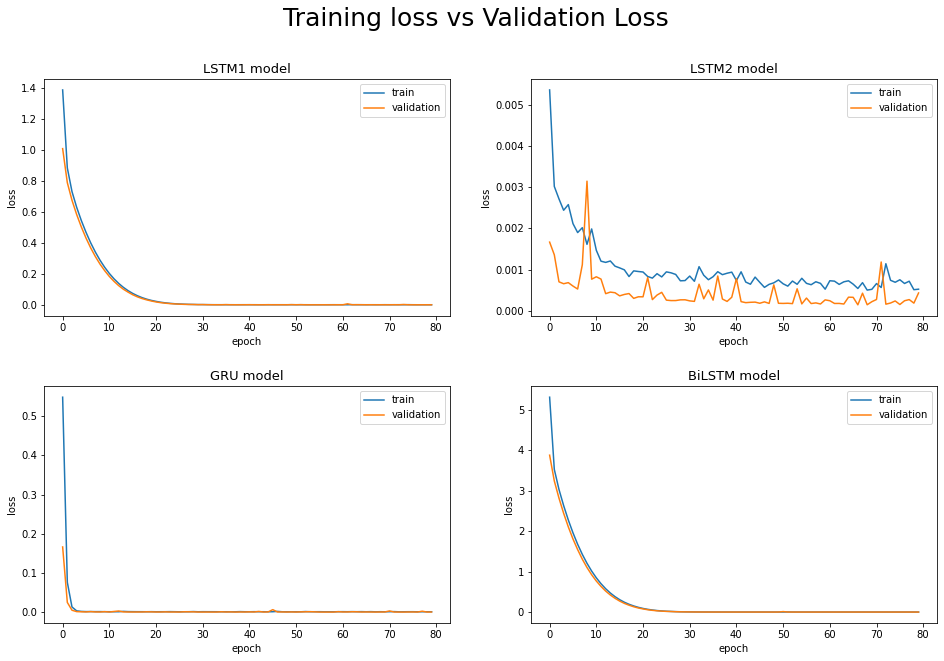

In [24]:
def plot_loss_histories(histories,names):
    rows = math.ceil(len(histories)/2)
    fig, axes = plt.subplots(rows,2, constrained_layout=False, figsize=(16,5*rows))
    fig.suptitle("Training loss vs Validation Loss\n", fontsize=25)
    # Draw nested boxplots
    for history, name, ax in zip(histories, names , axes.flatten()):
        ax.plot(history.history['loss'])
        ax.plot(history.history['val_loss'])
        ax.set_title("{} model".format(name), fontsize=13)
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(['train', 'validation'], loc='upper right')
    fig.subplots_adjust(hspace=0.3)
    plt.show()
    
histories = [history1,history2,history3,history4]
names = ['LSTM1','LSTM2','GRU','BiLSTM']
plot_loss_histories(histories,names)

## Prediction
### 1. Valid Set

In [25]:
def pred_val(model, df, input):
    target_scaler = MinMaxScaler()
    target_scaler.fit(train_df[['Close']])
    #Get the models predicted price values
    predictions = model.predict(input)
    predictions = target_scaler.inverse_transform(predictions)
    valid=df[15:][['Close']].copy()
    valid['Predictions'] = predictions
    #get the root mean squared error (RMSE)
    rmse = np.sqrt(np.mean(valid['Predictions'] - valid['Close']) ** 2)
    print("RMSE:",rmse)
    print("Accuracy:",accuracy_forecast(valid['Close'], valid['Predictions']),'\n')
    return predictions, rmse

scores = {}
print('LSTM1')
LSTM1_pred_val, rmse = pred_val(LSTM1,val_df,x_val)
scores['LSTM1'] = rmse
print('LSTM2')
LSTM2_pred_val, rmse = pred_val(LSTM2,val_df,x_val)
scores['LSTM2'] = rmse
print('GRU')
GRU_pred_val, rmse = pred_val(GRU_model,val_df,x_val)
scores['GRU'] = rmse
print('BiLSTM')
bilstm_pred_val, rmse = pred_val(biLSTM,val_df,x_val)
scores['BiLSTM'] = rmse

LSTM1
RMSE: 0.05888103086798994
Accuracy: 0.4745762711864407 

LSTM2
RMSE: 5.606489374167455
Accuracy: 0.48184019370460046 

GRU
RMSE: 4.751997842579298
Accuracy: 0.4552058111380145 

BiLSTM
RMSE: 2.930928892861014
Accuracy: 0.4794188861985472 



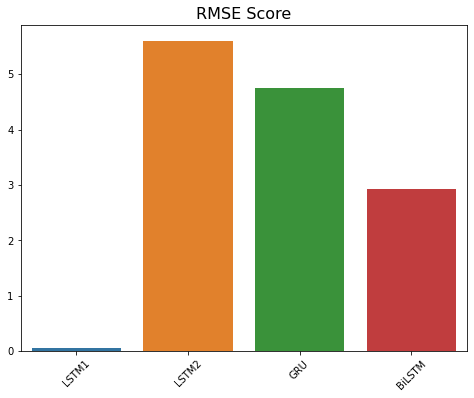

In [26]:
plt.figure(figsize=(8, 6))
sns.barplot(y = pd.Series(scores).values, x = pd.Series(scores).index)
plt.xticks(rotation=0)
plt.title('RMSE Score', fontsize=16)
plt.xticks(rotation = 45)
plt.show()

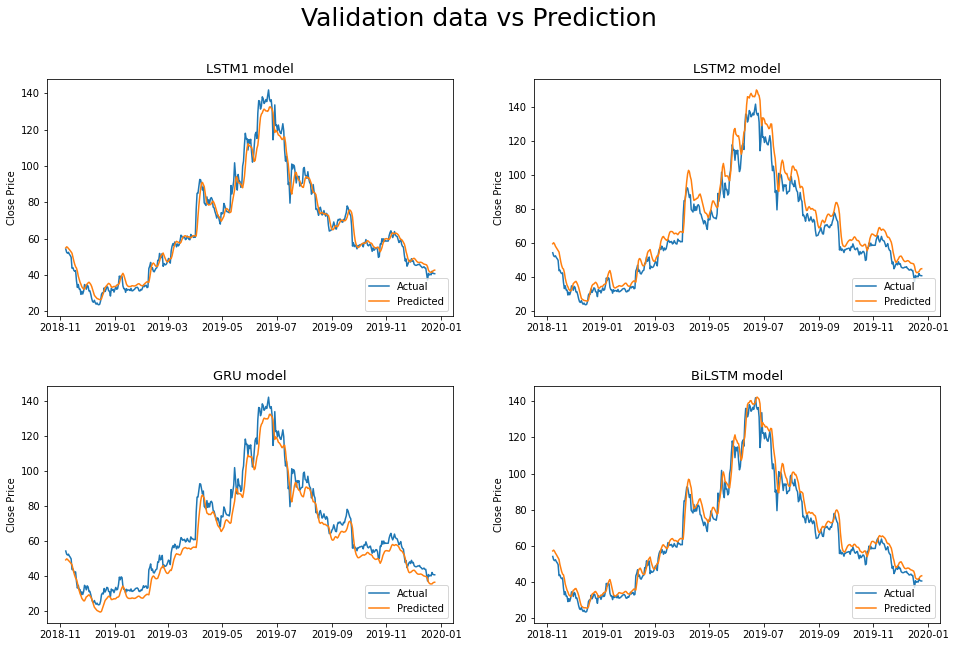

In [27]:
def plot_predictions(predictions,names):
    rows = math.ceil(len(predictions)/2)
    fig, axes = plt.subplots(rows,2, constrained_layout=False, figsize=(16,5*rows))
    fig.suptitle("Validation data vs Prediction\n", fontsize=25)
    # Draw nested boxplots
    for prediction, name, ax in zip(predictions, names , axes.flatten()):
        valid = val_df[['Close']][15:].copy()
        valid['Predictions'] = prediction
        ax.plot(valid[['Close', 'Predictions']])
        ax.set_title("{} model".format(name), fontsize=13)
        ax.set_ylabel('Close Price')
        ax.legend(['Actual', 'Predicted'], loc='lower right')
    fig.subplots_adjust(hspace=0.3)
    plt.show()

predictions = [LSTM1_pred_val,LSTM2_pred_val,GRU_pred_val,bilstm_pred_val]
names = ['LSTM1','LSTM2','GRU','BiLSTM']
plot_predictions(predictions,names)


### 2.Test Set

In [28]:
n = df.shape[0]
train_df = df[0:int(n*.85)]
test_df = df[int(n*0.85):]

def scale_func(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    scaled_data = pd.DataFrame(scaled_data,index=df.index, columns=df.columns)
    return scaled_data, scaler

scaled_train_df, scaler  = scale_func(train_df) 
scaled_test_df = pd.DataFrame(scaler.transform(test_df),index=test_df.index,columns=test_df.columns)

In [29]:
x_train, y_train = generate_input(scaled_train_df,15, "Close")
x_test, y_test = generate_input(scaled_test_df,15, "Close")
print("Training set:",x_train.shape)
print("Test set:",x_test.shape)

Training set: (2417, 15, 1)
Test set: (415, 15, 1)


In [30]:
LSTM1 = model_base_build(input_shape= (x_train.shape[1],x_train.shape[2]))
LSTM2 = model_class_build(input_shape= (x_train.shape[1],x_train.shape[2]))
GRU_model = model_GRU_build(input_shape= (x_train.shape[1],x_train.shape[2]))
biLSTM = biLSTM_model(input_shape= (x_train.shape[1],x_train.shape[2]))

In [31]:
history1 = LSTM1.fit(x_train, y_train, batch_size=32, epochs=80,validation_data=(x_test,y_test))
history2 = LSTM2.fit(x_train, y_train, batch_size=32, epochs=80,validation_data=(x_test,y_test))
history3 = GRU_model.fit(x_train, y_train, batch_size=32, epochs=80,validation_data=(x_test,y_test))
history4 = biLSTM.fit(x_train, y_train, batch_size=32, epochs=80,validation_data=(x_test,y_test))

h 49/80
76/76 [==============================] - 2s 23ms/step - loss: 6.4264e-04 - val_loss: 3.0392e-04
Epoch 50/80
76/76 [==============================] - 2s 22ms/step - loss: 7.7610e-04 - val_loss: 3.5198e-04
Epoch 51/80
76/76 [==============================] - 2s 22ms/step - loss: 5.0700e-04 - val_loss: 4.4078e-04
Epoch 52/80
76/76 [==============================] - 2s 23ms/step - loss: 5.9016e-04 - val_loss: 2.9903e-04
Epoch 53/80
76/76 [==============================] - 2s 22ms/step - loss: 7.4866e-04 - val_loss: 3.2607e-04
Epoch 54/80
76/76 [==============================] - 2s 22ms/step - loss: 4.0442e-04 - val_loss: 3.2158e-04
Epoch 55/80
76/76 [==============================] - 2s 23ms/step - loss: 6.0704e-04 - val_loss: 2.9770e-04
Epoch 56/80
76/76 [==============================] - 2s 22ms/step - loss: 5.1716e-04 - val_loss: 3.0466e-04
Epoch 57/80
76/76 [==============================] - 2s 22ms/step - loss: 4.3401e-04 - val_loss: 3.9079e-04
Epoch 58/80
76/76 [=============

In [32]:
scores = {}
print('LSTM1')
LSTM1_pred_val, rmse = pred_val(LSTM1,test_df,x_test)
scores['LSTM1'] = rmse
print('LSTM2')
LSTM2_pred_val, rmse = pred_val(LSTM2,test_df,x_test)
scores['LSTM2'] = rmse
print('GRU')
GRU_pred_val, rmse = pred_val(GRU_model,test_df,x_test)
scores['GRU'] = rmse
print('BiLSTM')
bilstm_pred_val, rmse = pred_val(biLSTM,test_df,x_test)
scores['BiLSTM'] = rmse

LSTM1
RMSE: 3.039121976471574
Accuracy: 0.4806763285024155 

LSTM2
RMSE: 3.1553235564732236
Accuracy: 0.4927536231884058 

GRU
RMSE: 4.182705628094667
Accuracy: 0.4830917874396135 

BiLSTM
RMSE: 2.5631571981689114
Accuracy: 0.4758454106280193 



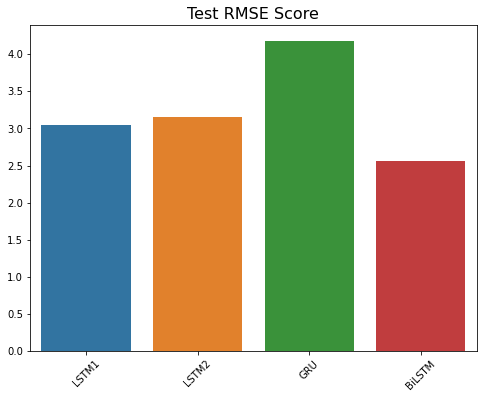

In [33]:
plt.figure(figsize=(8, 6))
sns.barplot(y = pd.Series(scores).values, x = pd.Series(scores).index)
plt.xticks(rotation=0)
plt.title('Test RMSE Score', fontsize=16)
plt.xticks(rotation = 45)
plt.show()

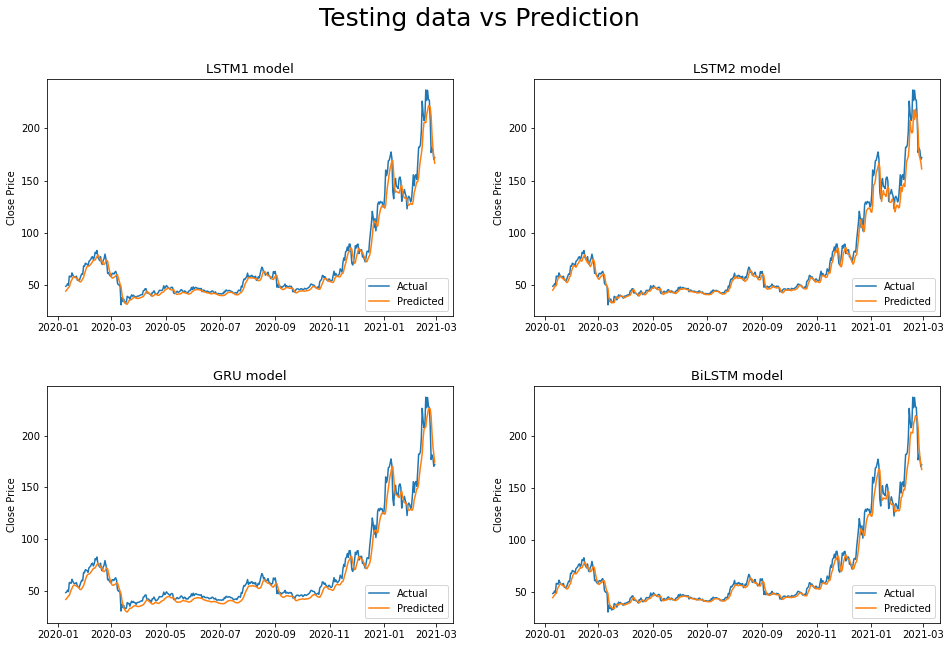

In [34]:
def plot_predictions(predictions,names):
    rows = math.ceil(len(predictions)/2)
    fig, axes = plt.subplots(rows,2, constrained_layout=False, figsize=(16,5*rows))
    fig.suptitle("Testing data vs Prediction\n", fontsize=25)
    # Draw nested boxplots
    for prediction, name, ax in zip(predictions, names , axes.flatten()):
        valid = test_df[['Close']][15:].copy()
        valid['Predictions'] = prediction
        ax.plot(valid[['Close', 'Predictions']])
        ax.set_title("{} model".format(name), fontsize=13)
        ax.set_ylabel('Close Price')
        ax.legend(['Actual', 'Predicted'], loc='lower right')
    fig.subplots_adjust(hspace=0.3)
    plt.show()


predictions = [LSTM1_pred_val,LSTM2_pred_val,GRU_pred_val,bilstm_pred_val]
names = ['LSTM1','LSTM2','GRU','BiLSTM']
plot_predictions(predictions,names)

In [35]:
LINK_quote = web.DataReader('LTC-USD', data_source='yahoo', start='2021-03-01', end='2021-03-21')
#create a new dataframe
new_df = LINK_quote.drop(['Adj Close'],axis =1)
scaler = MinMaxScaler().fit(df.drop('Marketcap',axis =1))
new_df = pd.DataFrame(scaler.transform(new_df),columns=new_df.columns,index = new_df.index)
#Get the last 60 day closing price
X_test, y_test = generate_input(new_df,15,"Close")
y_test = LINK_quote['Close'][-7:]

# 1-day step prediction

In [36]:
pred_price1 = LSTM1.predict(X_test)
pred_price2 = LSTM2.predict(X_test)
pred_price3 = GRU_model.predict(X_test)
pred_price4 = biLSTM.predict(X_test)
#undo scaling
target_scaler = MinMaxScaler()
target_scaler.fit(df[['Close']])
pred_price1 = target_scaler.inverse_transform(pred_price1).reshape(-1)
pred_price2 = target_scaler.inverse_transform(pred_price2).reshape(-1)
pred_price3 = target_scaler.inverse_transform(pred_price3).reshape(-1)
pred_price4 = target_scaler.inverse_transform(pred_price4).reshape(-1)

In [37]:
valid1 = pd.DataFrame({'Close':y_test.values,'Predictions':pred_price1},index = new_df.iloc[-7:,:].index)
valid2 = pd.DataFrame({'Close':y_test.values,'Predictions':pred_price2},index = new_df.iloc[-7:,:].index)
valid3 = pd.DataFrame({'Close':y_test.values,'Predictions':pred_price3},index = new_df.iloc[-7:,:].index)
valid4 = pd.DataFrame({'Close':y_test.values,'Predictions':pred_price4},index = new_df.iloc[-7:,:].index)

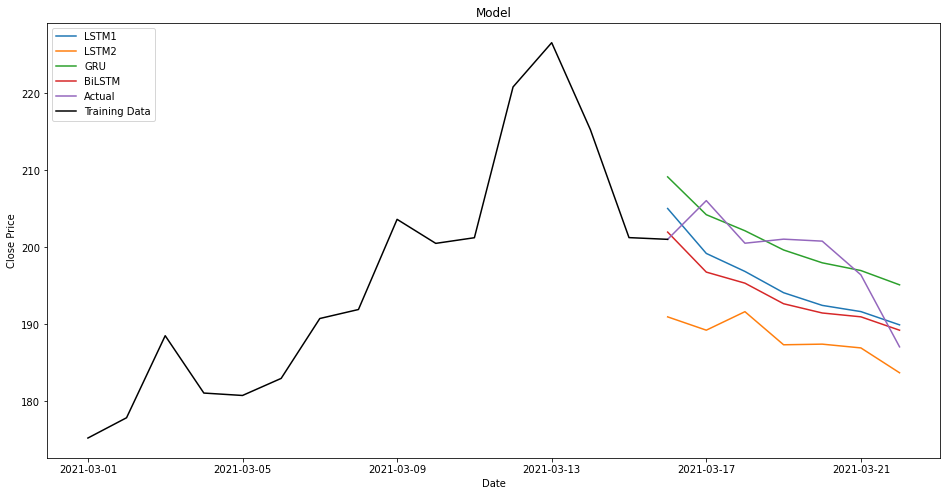

In [38]:
#visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(valid1['Predictions'],label='Line 1')
plt.plot(valid2['Predictions'])
plt.plot(valid3['Predictions'])
plt.plot(valid4[['Predictions', 'Close']])
plt.plot(LINK_quote.iloc[:-6,:]["Close"],color = 'black')
plt.legend(['LSTM1','LSTM2','GRU','BiLSTM','Actual','Training Data'], loc='upper left')
plt.show()

# 7-day steps prediction

In [39]:
# make a forecast
def forecast(model, X_test, pred_len = 7):
    # retrieve last observations for input data
    input_x = X_test[0]
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, len(input_x), 1))
    outputs = np.array([])
    for i in range(pred_len):
        # forecast the next week
        yhat = model.predict(input_x, verbose=0)
        outputs = np.append(outputs,target_scaler.inverse_transform(yhat))
        # we only want the vector forecast
        yhat = yhat[0]
        input_x = np.append(input_x[0][1:],yhat)
        input_x = input_x.reshape((1, len(input_x), 1))        
    return outputs

In [40]:
valid1 = pd.DataFrame({'Close':y_test,'Predictions':forecast(LSTM1, X_test)},index = new_df.iloc[-7:,:].index)
valid2 = pd.DataFrame({'Close':y_test,'Predictions':forecast(LSTM2, X_test)},index = new_df.iloc[-7:,:].index)
valid3 = pd.DataFrame({'Close':y_test,'Predictions':forecast(GRU_model, X_test)},index = new_df.iloc[-7:,:].index)
valid4 = pd.DataFrame({'Close':y_test,'Predictions':forecast(biLSTM, X_test)},index = new_df.iloc[-7:,:].index)

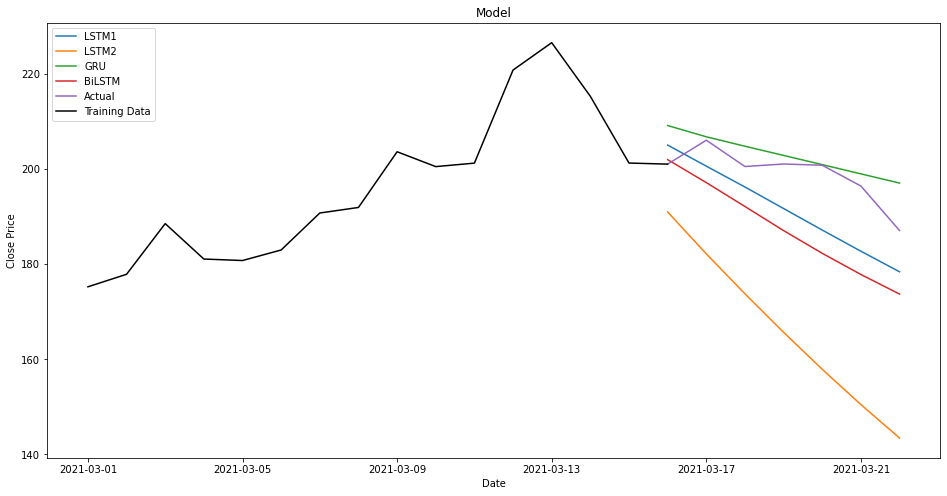

In [41]:
#visualize
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(valid1['Predictions'],label='Line 1')
plt.plot(valid2['Predictions'])
plt.plot(valid3['Predictions'])
plt.plot(valid4[['Predictions', 'Close']])
plt.plot(LINK_quote.iloc[:-6,:]["Close"],color = 'black')
plt.legend(['LSTM1','LSTM2','GRU','BiLSTM','Actual','Training Data'], loc='upper left')
plt.show()